# Statsmodel-SARIMA model

In [1]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Data loading

In [2]:
df_superstore  = pd.read_csv("./data/Sample - Superstore.csv")
df_superstore.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
furniture = df_superstore.loc[df_superstore['Category']=='Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

## Preprocessing Data

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture = furniture.drop(cols, axis=1)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [6]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture = furniture.set_index('Order Date')
furniture.index = pd.to_datetime(furniture.index)
furniture = furniture.sort_index()
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

<Axes: xlabel='Order Date'>

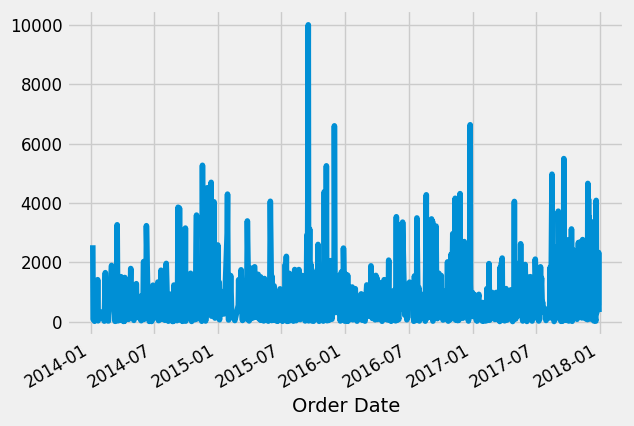

In [9]:
furniture['Sales'].plot()

### Resample data to monthly data

In [10]:
# monthly sales
y = furniture['Sales'].resample('MS').mean()

In [11]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#### Monthly furniture sales plot

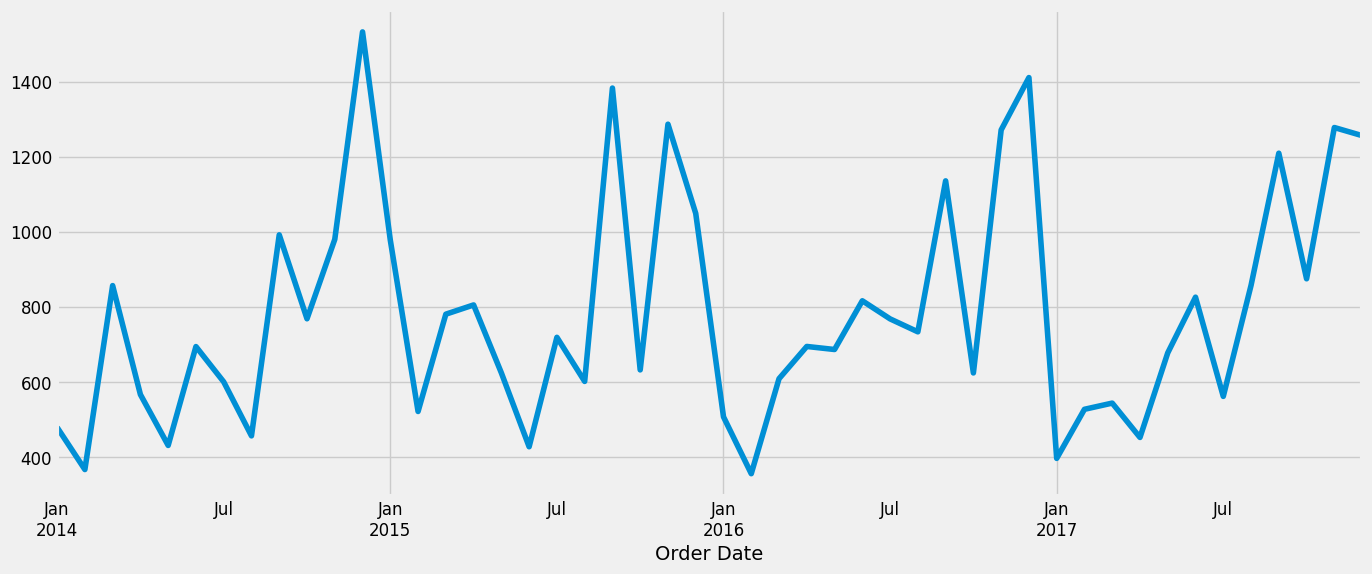

In [12]:
y.plot(figsize=(15, 6))
plt.show()

## TimeSeries Decomposition 

Time series decomposition helps us break down a time series dataset into three main components:

**Trend**: The trend component represents the long-term movement in the data, representing the underlying pattern.
**Seasonality**: The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.
**Residual (Noise)**: The residual component represents random variability that remains after removing the trend and seasonality.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

**Additive Decomposition**
$$Y(t) = Treand(t) + Seasonal(t) + Residual(t)$$
**Multiplicative Decomposition**
$$Y(t) = Treand(t) * Seasonal(t) * Residual(t)$$

Log transformation makes a multiplicative model into an additive decomposition
$$log(Y) = log(T)+log(S)+log(R)$$

There are more sophisticated methods: X13 decomposition or sesonal-trend decomposition using LOESS <br>

**Seasonal-Trend decomposition using LOESS (STL)**
Seasonal-Trend decomposition using Loess (STL) is a specific decomposition method that employs the Loess technique to separate a time series into its trend, seasonal, and residual components. STL is particularly effective in handling time series data with complex and non-linear patterns. In STL, the decomposition is performed by iteratively applying Loess smoothing to the time series. This process helps capture both short-term and long-term variations in the data, making it a robust method for decomposing time series with irregular or changing patterns. STL has some disadvantages. In particular, it does not handle trading day or calendar variation automatically, and it only provides facilities for additive decompositions.

**X13 ARIMA**
only for monthly or quarterly data.

These methods are designed to extract a single seasonal component from a time series.

Methods that can extract multiple seasonal components include Prophet, TBATS, and STR. Prophet and TBATS infer the seasonal components as part of training a forecasting model.

**In summary**
STL decomposition employs local regression (Loess) for more flexible and robust decomposition, while seasonal decomposition typically refers to classical methods that may use simpler techniques like moving averages or seasonal indices.

Reference:
1. [statsmodel-STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html)
2. [statsmodel-X13-ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_analysis.html)

**Why to perform seasonal decomposition?**
There are various reasons for performing seasonal decomposition in Time-series data which are discussed below:

1. Pattern Identification: Seasonal decomposition allows analysts to identify and understand the underlying patterns within a time series. This is crucial for recognizing recurring trends, seasonal effects and overall data behavior.
2. Forecasting: Separating a time series into its components facilitates more accurate forecasting. By modeling the trend, seasonal patterns and residuals separately, it becomes possible to make predictions and projections based on the individual components.
3. Anomaly Detection: Detecting anomalies or unusual events in a time series is more effective when the data is decomposed. Anomalies are easier to identify when they stand out against the background of the trend and seasonal patterns.
4. Statistical Analysis: Seasonal decomposition aids in statistical analysis by providing a clearer picture of the structure of the time series. This, in turn, enables the application of various statistical methods and models.

References:
1. [Seasonal decomposition of time series by loess (STL)](https://www.geeksforgeeks.org/seasonal-decomposition-of-time-series-by-loess-stl/)
2. [Seasonal trend decomposition using LOESS by sales analytics](https://www.salesanalytics.co.jp/datascience/datascience003/)
3. [STL decomposition by Hyndman](https://otexts.com/fpp2/stl.html)

### Classic decomposition

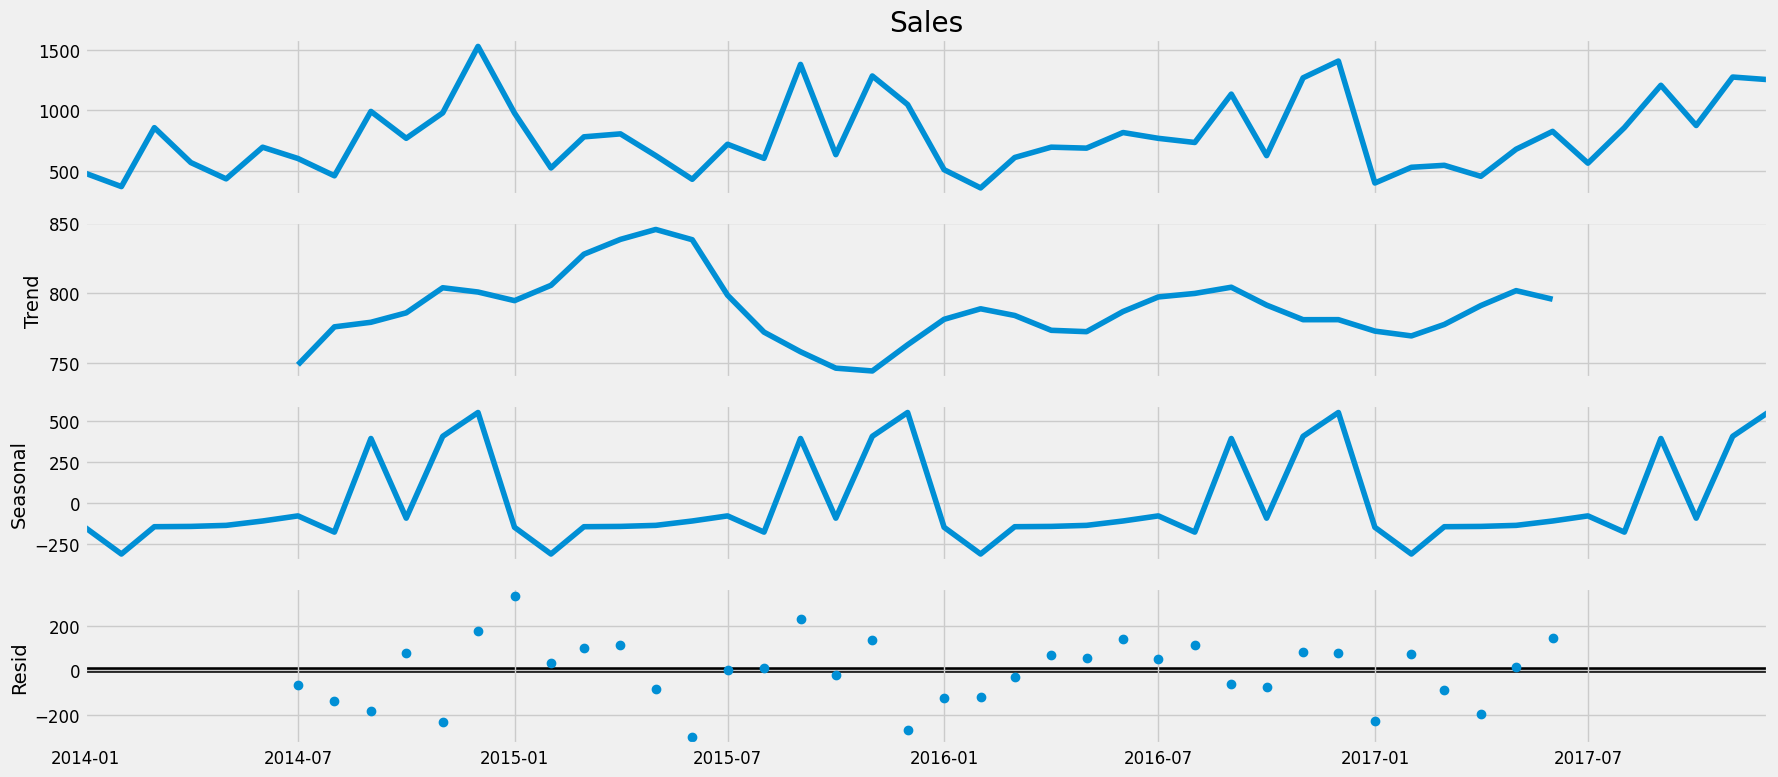

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
# additive model
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### STL decomposition

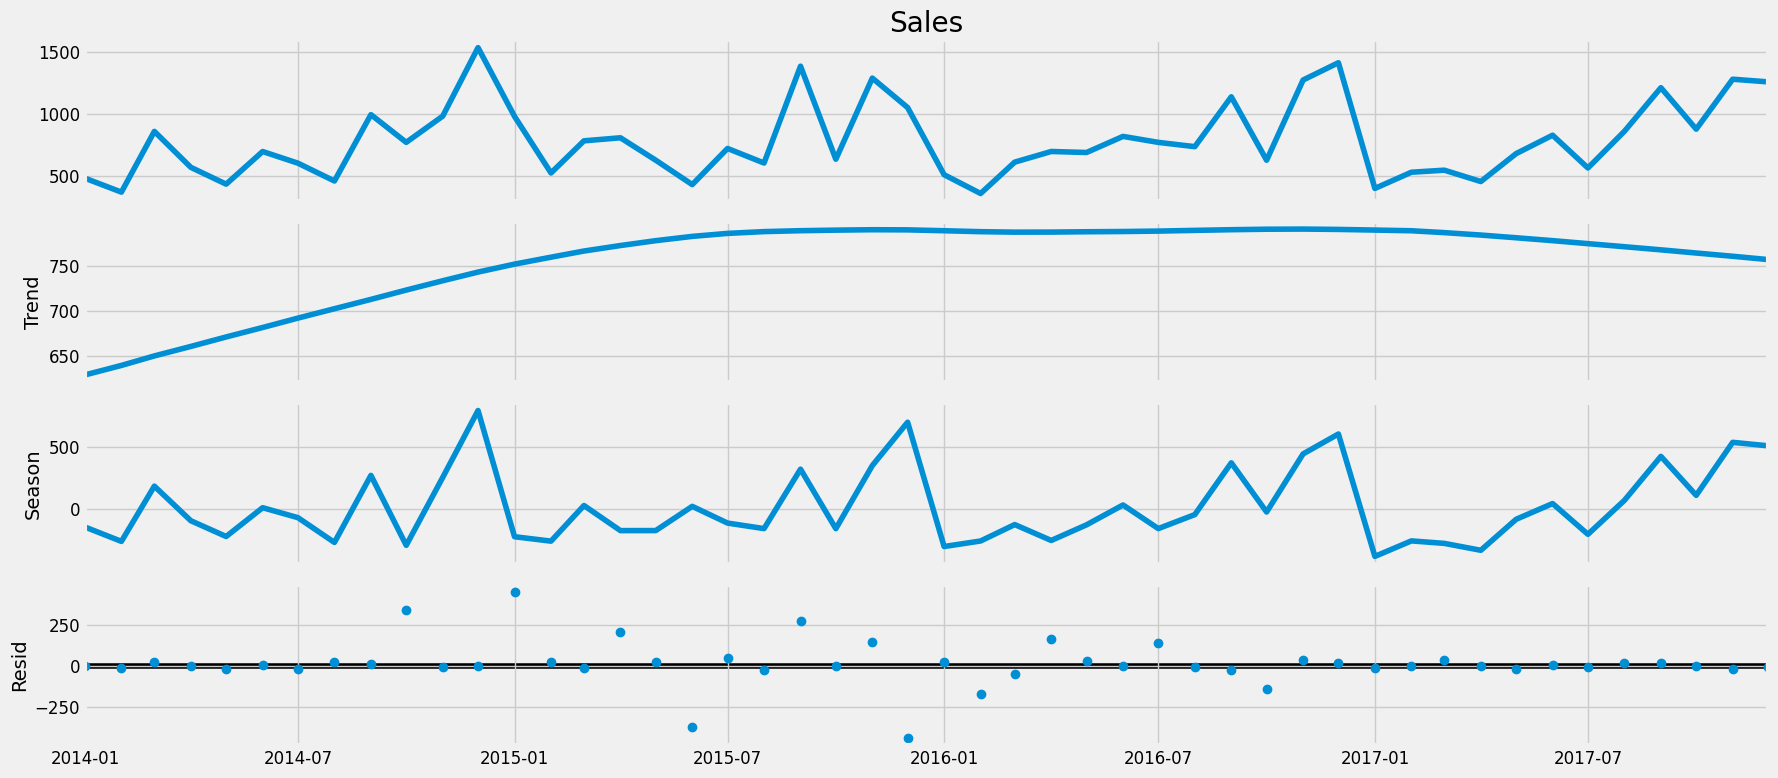

In [14]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(y, seasonal=13, robust=True)
stl_series = stl.fit()
# Plot the decomposition components
stl_series.plot()
plt.show()


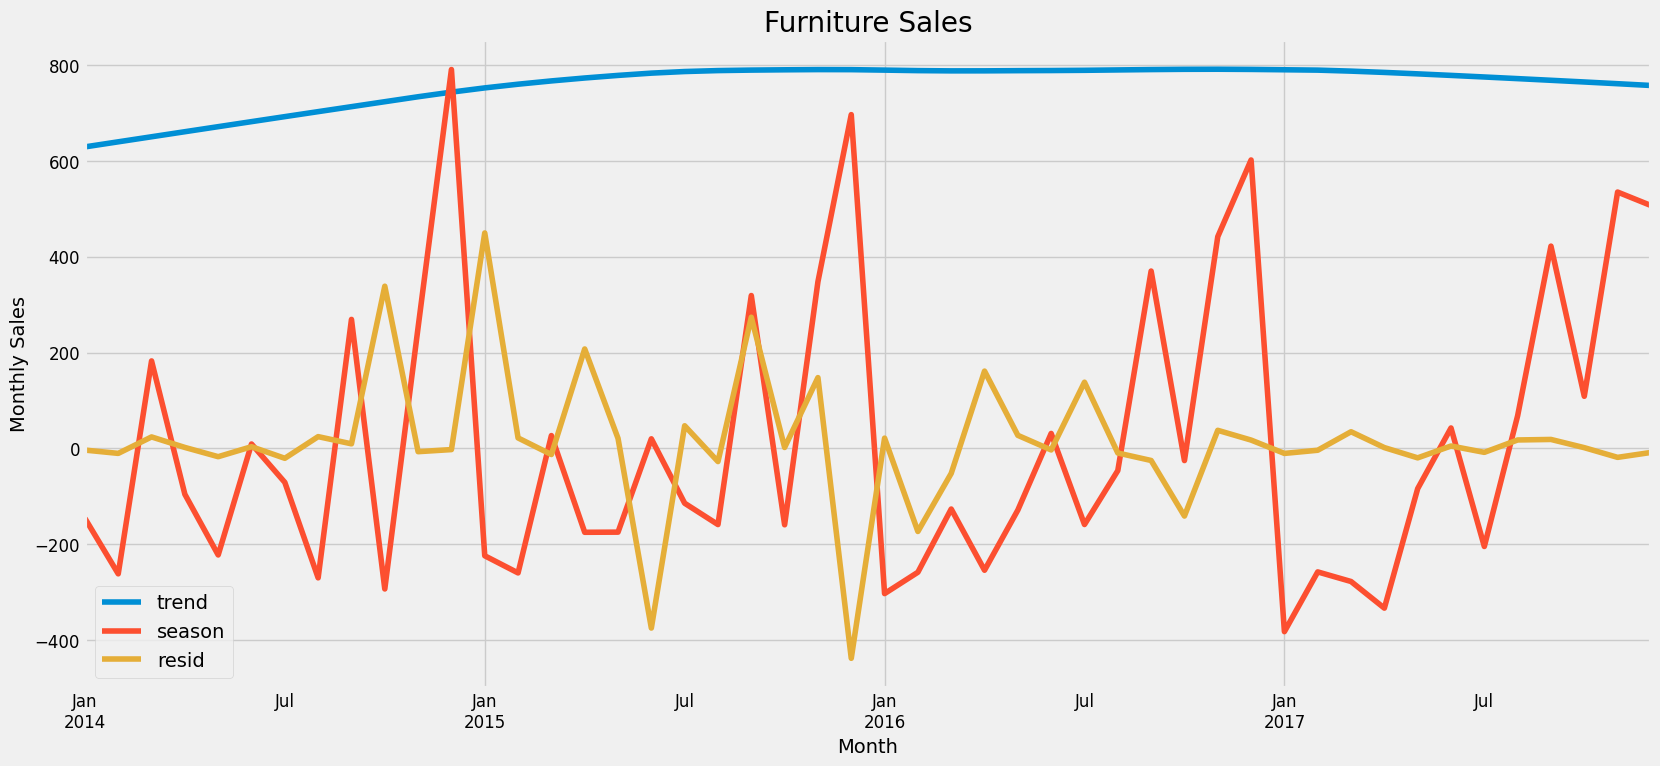

In [15]:
# extract each components
stl_o = stl_series.observed
stl_t = stl_series.trend
stl_s = stl_series.seasonal
stl_r = stl_series.resid

stl_t.plot()
stl_s.plot()
stl_r.plot()
plt.title('Furniture Sales')
plt.ylabel('Monthly Sales')
plt.xlabel('Month')
plt.legend()
plt.show()

## Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

#### Types of stationarity
* **Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions. <br>
* **Trend Stationary**: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.<br>
* **Difference Stationary**: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test. <br>

Reference : <br>
1. [stationarity and differencing](https://otexts.com/fpp2/stationarity.html) <br>
2. [An Introduction To Non Stationary Time Series In Python](https://www.analyticsvidhya.com/blog/2018/09/an-introduction-to-non-stationary-time-series-in-python/)

### Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

**The Augmented Dickey-Fuller test** is a type of statistical test called a unit root test.

In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. In simple terms, the unit root is non-stationary but does not always have a trend component.

ADF test is conducted with the following assumptions:

+ Null Hypothesis (HO): Series is non-stationary, or series has a unit root. <br>
+ Alternate Hypothesis(HA): Series is stationary, or series has no unit root. <br>

**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test** is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend.

The KPSS test is conducted with the following assumptions:

+ Null Hypothesis (HO): Series is trend stationary or series has no unit root.
+ Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.

*Note: The hypothesis is reversed in the KPSS test compared to ADF Test.*

The following are the possible outcomes of applying both tests.

*Case 1*: Both tests conclude that the given series is stationary – The series is stationary <br>
*Case 2*: Both tests conclude that the given series is non-stationary – The series is non-stationary <br>
*Case 3*: ADF concludes non-stationary, and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity. <br>
*Case 4*: ADF concludes stationary, and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity. <br>

**In summary**:

* The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data.
* The KPSS test is another popular test that checks for the trend stationarity of the data, and it is often used in conjunction with the ADF test.

reference: [stationarity in time series by Analytics vidhya](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/)

#### ADF test

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


#### KPSS test

In [17]:
# Function to print out results in customised manner
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(y)

Results of KPSS Test:
Test Statistic           0.19661
p-value                  0.10000
#Lags Used               2.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


Based on resutls of both the ADF and KPSS test, the condition falls into the case 1

> *Case 1*: Both tests conclude that the given series is stationary <br>

### Making stationary time series

**Differencing** <br>
The difference of consecutive terms in the series will be calculated. Differencing is typically performed to get rid of the varying mean.
differencing can be written as:

$$ y_t^‘ = y_t – y_{(t-1)} $$

where $y_t$ is the value at a time $t$

**Seasonal Differencing** <br>
In seasonal differencing, instead of calculating the difference between consecutive values, the difference between an observation and a previous observation from the same season will be calculated. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

$$y_t^‘ = y_t – y_{(t-n)} $$

n=7

To distinguish seasonal differences from ordinary differences, the ordinary differences is referred as “first differences”, meaning differences at lag 1.

**Transformation**
Transformations are used to stabilize the non-constant variance of a series. 
Common transformation methods include: 
* Log transforming of the data
* Taking the square root of the data
* Taking the cube root
* Proportional change

#### Test: making stationary time series

Since this data is stationary, the following step is not required. But the code is provided for illustration purpose.

Text(0.5, 1.0, 'Log transformation')

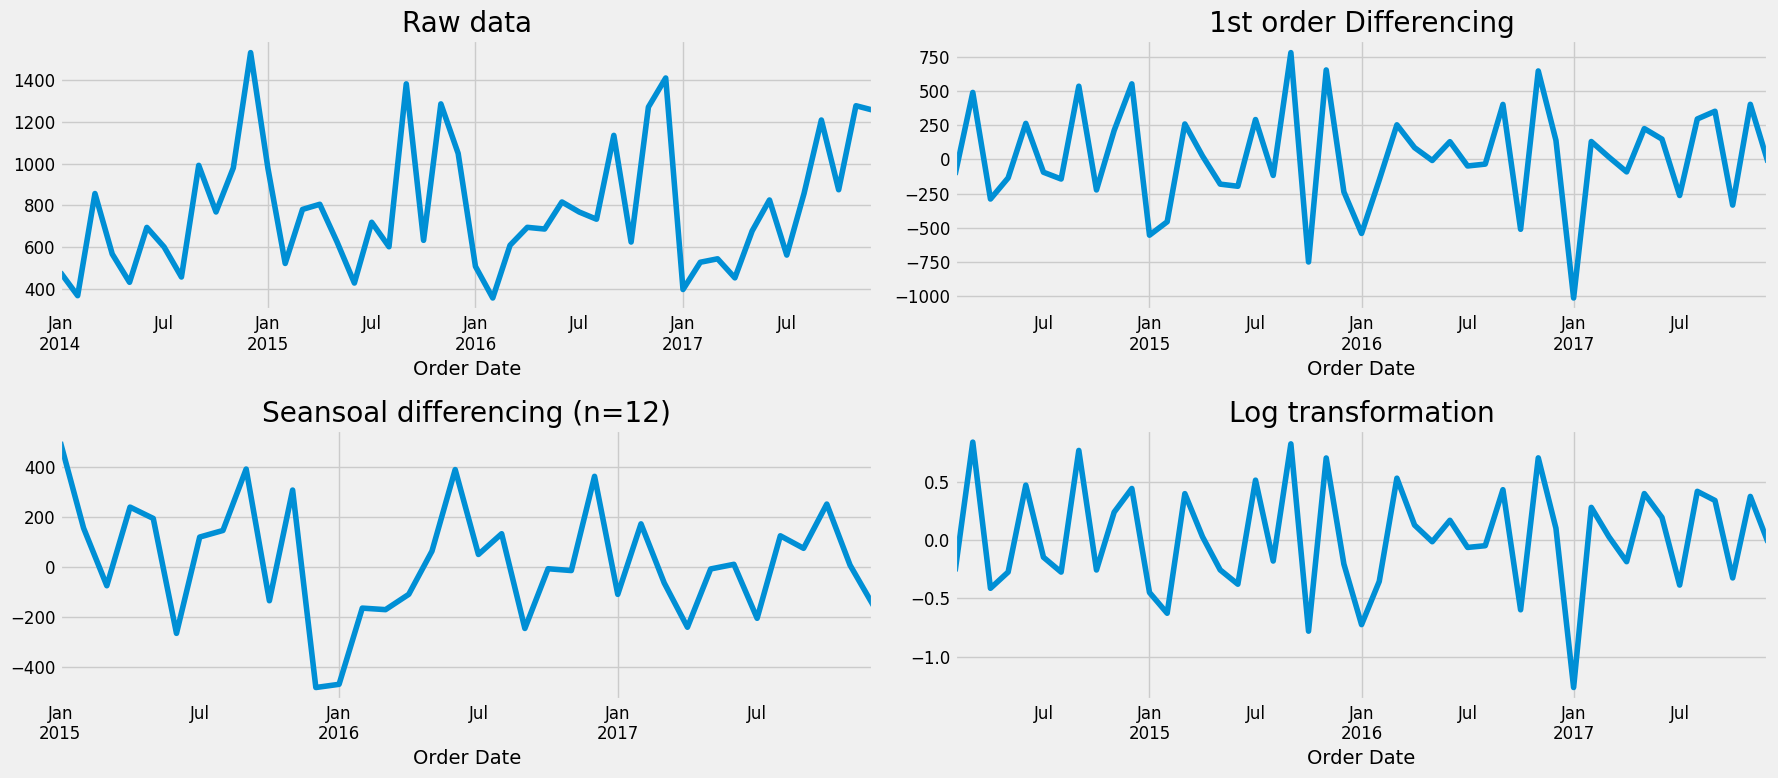

In [18]:
fig, ax = plt.subplots(2,2, tight_layout=True)

# original plot
y_test = y.copy()
y_test.dropna().plot(ax=ax[0,0])
ax[0,0].set_title('Raw data')

# differencing
y_test = y.copy()
y_test['Sales_diff'] = y_test - y_test.shift(1)
y_test['Sales_diff'].dropna().plot(ax=ax[0,1])
ax[0,1].set_title('1st order Differencing')

# seasonal differencing (n =12)
y_test = y.copy()
n = 12
y_test['Sales_seasonal_diff'] = y_test - y_test.shift(n)
y_test['Sales_seasonal_diff'].dropna().plot(ax=ax[1,0])
ax[1,0].set_title('Seansoal differencing (n=12)')

# transformation
y_test = y.copy()
y_test['Sales_log'] = np.log(y_test)
y_test['Sales_log_diff'] = y_test['Sales_log'] - y_test['Sales_log'].shift(1)
y_test['Sales_log_diff'].dropna().plot(ax=ax[1,1])
ax[1,1].set_title('Log transformation')

## Autocorrelation (ACF) and partial autocorrelation (PACF)

* **Autocorrelation Function (ACF)**: <br>
The ACF plot is a graphical representation of the correlation of a time series with itself at different lags. The ACF plot can be used to identify the order of an AR model.  <br>
* **Partial Autocorrelation Function (PACF)**: <br>
The PACF plot is a graphical representation of the correlation of a time series with itself at different lags, after removing the effects of the previous lags. The PACF plot can be used to identify the order of an MA model.

ACF and PACF plots help in detecting autocorrealtion and seasonality.

**Interpretaion**

* If the ACF plot shows spikes at the first few lags, then an AR model may be appropriate.
* If the PACF plot shows spikes at the first few lags, then an MA model may be appropriate.
* If the ACF and PACF plots both show spikes at the first few lags, then an ARMA model may be appropriate.


Reference: <br>
* [What are ACF and PACF Plots in Time Series Analysis?](https://ilyasbinsalih.medium.com/what-are-acf-and-pacf-plots-in-time-series-analysis-cb586b119c5d)

* [Time series Forecasting — ARIMA models](https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06)

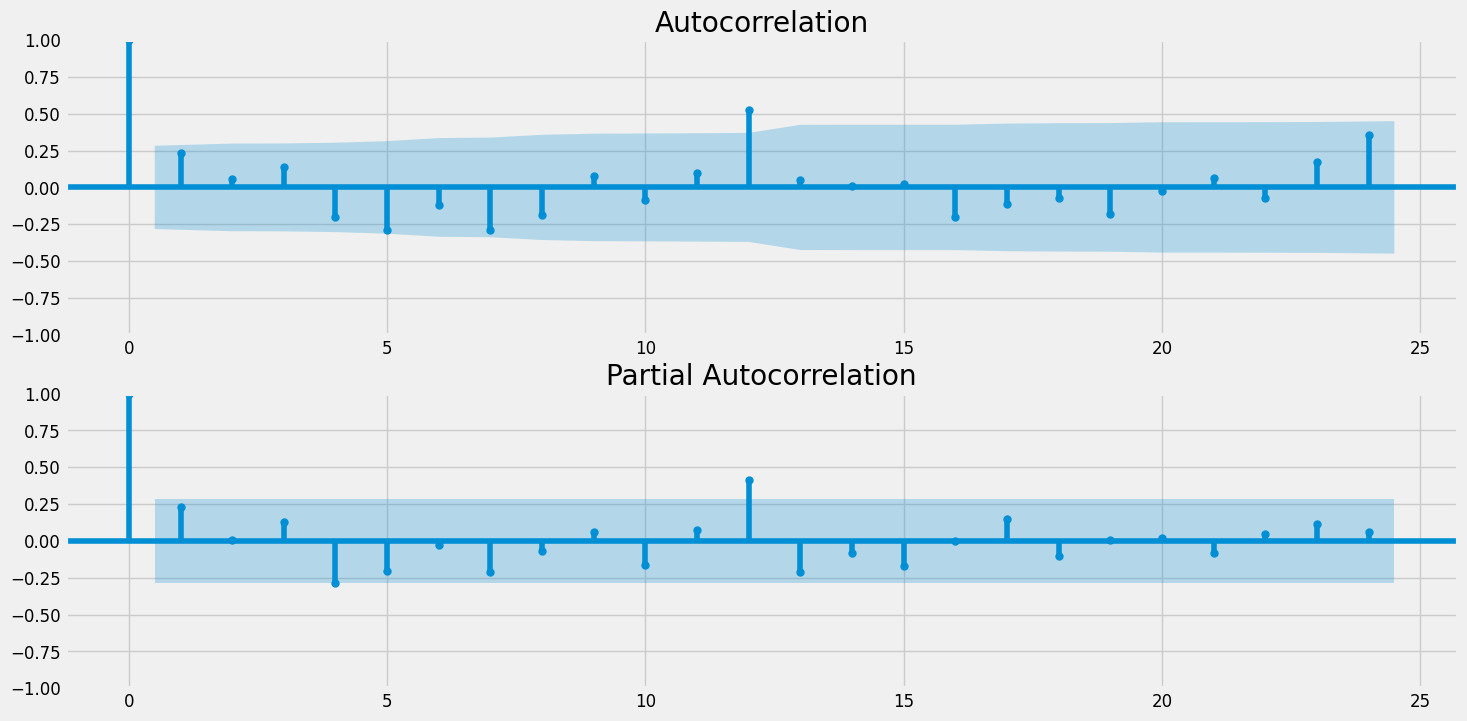

In [19]:
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

lags = 24
plot_acf(y, lags=lags, ax=ax[0])
plot_pacf(y, lags=lags, ax=ax[1])
plt.show()


## Modeling

Time series can be either univariate or multivariate:

**Univariate** time series only has a single time-dependent variable. <br>
For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

**Multivariate** time series have a multiple time-dependent variable. <br>
For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

## SARIMA model


**ARIMA Models** are specified by three order parameters: (p, d, q),

where,

- **p**: The lag order (AR term), representing the number of lag observations incorporated in the model.
- **d**: Degree of differencing, denoting the number of times raw observations undergo differencing to make the time series stationary.
- **q**: Order of moving average (MA term), indicating the size of the moving average window.

**SARIMA model**

* The plain ARIMA model has a problem. It does not support seasonality.
* If the time series has defined seasonality, then we should go for Seasonal ARIMA model (in short SARIMA) which uses seasonal differencing.
* Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.

The model will be represented as SARIMA(p,d,q)x(P,D,Q), 

where, 

The lowercase parameters refer to the non-seasonal compoenents, and the uppercase parameters represent the seasonal components

- **p** and **seasonal P**: number of autoregressive terms (lags of the stationarized series)
- **d** and **seasonal D**: differencing that must be done to stationarize series
- **q** and **seasonal Q**: number of moving average terms (lags of the forecast errors)
- **s** : seasonal length in the data

In [37]:
ps = qs = Ps = Qs = range(0, 3, 1)
ds = Ds = range(0,2,1)
SARIMA_order_list = list(itertools.product(ps, ds, qs, Ps, Ds, Qs))

s = 12

print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {SARIMA_order_list[0]}')
print(f'SARIMAX: {SARIMA_order_list[1]}')


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0, 0, 0, 0)
SARIMAX: (0, 0, 0, 0, 0, 1)


## Optimize parameters

**AIC** stands for Akaike Information Criterion. It is a statistical measure used to evaluate the quality of a model by balancing its goodness of fit with its complexity (number of parameters). The AIC is commonly used in model selection, including the selection of SARIMA models.

The AIC takes into account both the model’s ability to fit the data and the number of parameters used in the model. The formula for calculating AIC is as follows:
$$ AIC = 2k - 2ln(\hat{L})$$

where: <br>
&nbsp;&nbsp; $k$ : number of estimated parameters in the model <br>
&nbsp;&nbsp; $\hat{L}$ : maximum value of the likelihood function for the model<br>

In general, a lower AIC score indicates a better model fit, especially when comparing different models on the same dataset. 

In [32]:
SIZE = 12
train = y[:-SIZE]
test = y[-SIZE:]
print(f'Sample Size:\ny : {y.shape}\ntrain : {train.shape}\ntest : {test.shape}')

Sample Size:
y : (48,)
train : (36,)
test : (12,)


In [38]:
arima_params = {'parameters':[],
                's': s,
                'AIC':[]}
for order in tqdm(SARIMA_order_list):
    try:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=(order[0],order[1], order[2]),
                                        seasonal_order=(order[3],order[4],order[5],s)
                                        )
        results = mod.fit(disp=0)
        arima_params['parameters'].append(order)
        arima_params['AIC'].append(results.aic)
    except:
        continue


  0%|          | 0/324 [00:00<?, ?it/s]

In [39]:
df_arima_params = pd.DataFrame(arima_params)
df_arima_params = df_arima_params.sort_values('AIC')
df_arima_params.head(10)

,parameters,s,AIC
17,"(0, 0, 0, 2, 1, 2)",12,10.000000
308,"(2, 1, 2, 1, 0, 1)",12,14.000000
81,"(0, 1, 1, 1, 1, 0)",12,320.663989
188,"(1, 1, 1, 1, 1, 0)",12,322.244750
99,"(0, 1, 2, 1, 1, 0)",12,322.302653
82,"(0, 1, 1, 1, 1, 1)",12,322.586875
87,"(0, 1, 1, 2, 1, 0)",12,322.630765
77,"(0, 1, 1, 0, 1, 2)",12,322.848834
76,"(0, 1, 1, 0, 1, 1)",12,323.368907
194,"(1, 1, 1, 2, 1, 0)",12,324.013437


In [70]:
order = (1,1,1)
seasonal_order = (1,1,0,12)

mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.238      0.284      0.776      -0.398       0.534
ma.L1         -0.9988      9.431     -0.106      0.916     -19.484      17.486
ar.S.L12      -0.4807      0.148     -3.248      0.001      -0.771      -0.191
sigma2      4.113e+04   3.83e+05      0.107      0.914   -7.09e+05    7.91e+05


### Diagnostic plot

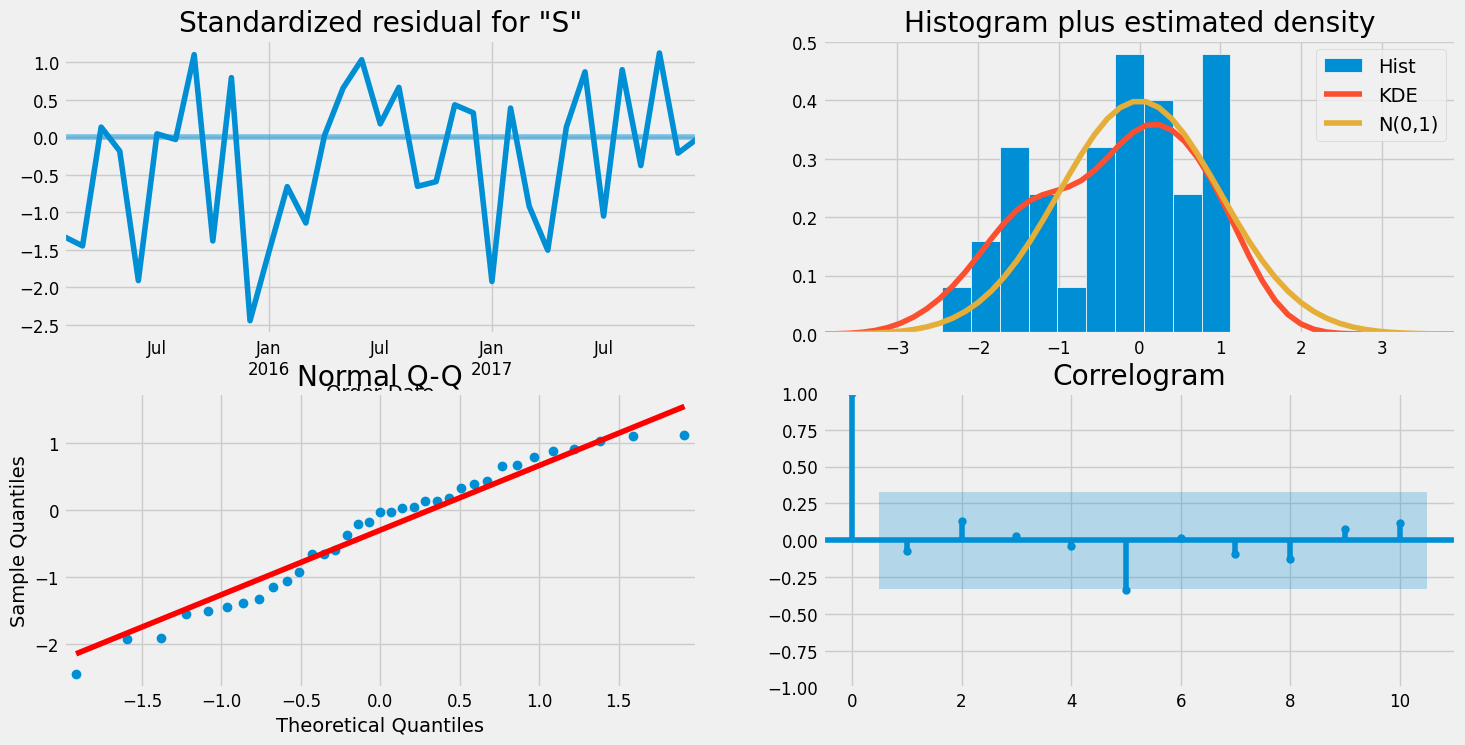

In [71]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Interpretation of plots in plot diagnostics
* **Standardized residual**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance. Any obvious patterns should not be recognized.

* **Histogram**: The density plot suggest normal distribution with mean slighlty shifted towards right.

* **Theoretical Quantiles (Q-Q plot)**: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

* **Correlogram**: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. Any pattern in the residual errors in the ACF plot would implay that there are the residual errors which are not explained in the model. You may look for more X’s (predictors) to the model.


### Ljung–Box test

In [72]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = results.resid
acorr_ljungbox(residuals, np.arange(1,11,1))

,lb_stat,lb_pvalue
1,0.765792,0.381522
2,1.030332,0.597401
3,1.577670,0.664463
4,2.986600,0.560070
5,3.164495,0.674642
6,3.171914,0.786981
7,4.647745,0.702861
8,4.647861,0.794464
9,6.540571,0.684831
10,6.549608,0.767170


The residulas are independent and uncorrelated.

## Model Validation

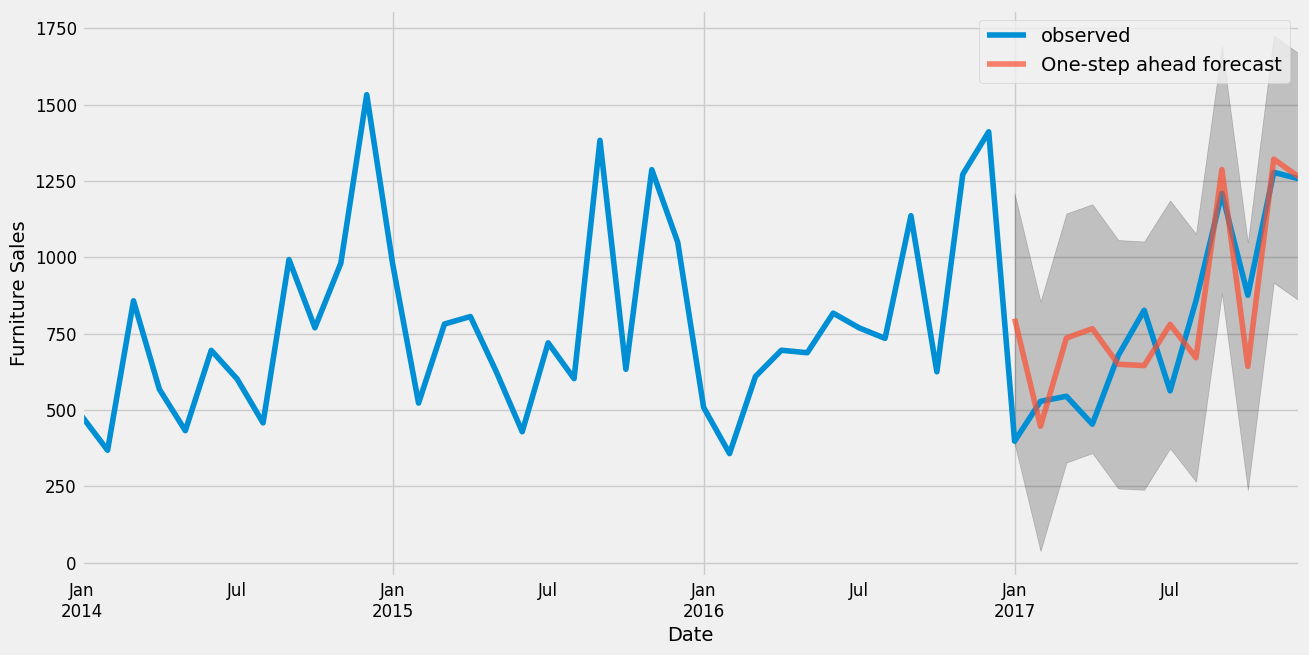

In [73]:
pred_start = pd.to_datetime('2017-01-01')
pred = results.get_prediction(start=pred_start, dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Mean squared error (MSE) and root mean squared error (RMSE)

The **mean squred error** and **root mean squared error** are used to evaluate the performanece of the model in machine learning models.

The mean squared error (MSE) represents the average of the squared difference between the true and predicted values in the dataset. It measures the variance of the residuals.

$$MSE = \frac{1}{N} \Sigma_{i=1}^N (y_i - \hat{y})^2$$

The root mean squared error (RMSE) is the square root of mean squared error. It measures the standard deviation of residuals.

$$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N} \Sigma_{i=1}^N (y_i - \hat{y})^2}$$

RMSE is measured in the same units as the predictors while MSE is measured in the squred units. Thus, the interpretation of RMSE is more straightfoward than MSE.

reference:
1. [MSE and RMSE](https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e)
2. [MSE vs RMSE: Which metric shoudl you use?](https://www.statology.org/mse-vs-rmse/)

In [78]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse_SARIMA = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts with the SARIMA model is {mse_SARIMA:.2f}')
print(f'The Root Mean Squared Error of our forecasts with the SARIMA model is {np.sqrt(mse_SARIMA):.2f}')

The Mean Squared Error of our forecasts with the SARIMA model is 39997.15
The Root Mean Squared Error of our forecasts with the SARIMA model is 199.99


## Forecasting

Out-ouf-sample forecasts are produced using the `forecast` or `get_forecast` methods.

* **forecast**: one-step-ahead forecast <br>

* **get_forecast**: more general forecasting with confidence intervals<br>

In [58]:
# get a one-step-ahead forecast
print(results.forecast())

2017-01-01    925.19029
Freq: MS, dtype: float64


get_forecasting in statsmodels

`SARIMAXResults.get_forecast(steps=1, signal_only=False, **kwargs)`

Parameters:
* **steps**: If an integer, the number of steps to forecast from the end of the sample

*Prediction vs Forecasting*

In-sample fitted values, you could use `predict` and `get_prediction` similar to `forecast` and `get_forecast`. In general, if your interest is out-of-sample forecasting, it is easier to stick to the `forecast` and `get_forecast` methods.

Reference: [SARIMAXResutls.get_forecast()](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_forecast.html)

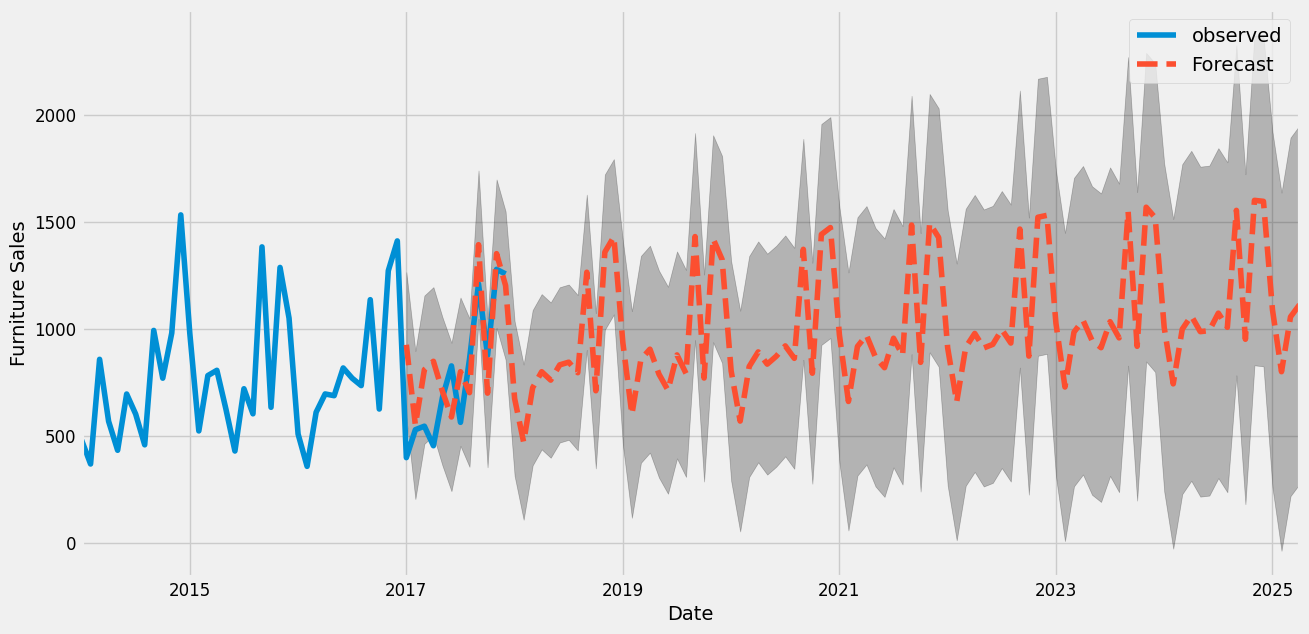

In [59]:
# steps indicating the 100 steps to forecast from the end of the sample
pred_uc = results.get_forecast(steps=100)

# summary frame contains predicted values
# default alpha parameter for confidence interval is 95% (0.95)
# display(pred_uc.summary_frame())

pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', style='--')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25) # alpha is an opacity parameter not a confidence interval parameter
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The model capture the seasonal pattern. As we forecast further in the future, it is natural that the model is less confidence in prediction. 

## Appendix

### Semi-auto way to determine parameters 

[A “semi-auto” way to determine parameters for SARIMA model](https://tsanggeorge.medium.com/a-semi-auto-way-to-determine-parameters-for-sarima-model-74cdee853080) written by George Tsang in medium

In [60]:
# semi-grid-searching SARIMA parameters
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store parameter values
    model_info = []

    #fit the model
    from statsmodels.tools.eval_measures import rmse
    for i in order:
        for j in seasonal_order:
            try:
                model = sm.tsa.statespace.SARIMAX(endog=endog, order=i, seasonal_order=j)
                result = model.fit(disp=0)
                predict = result.predict()

                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                RMSE = rmse(endog[1:], predict[1:])
                AIC = result.aic
                BIC = result.bic

                # create a list of order, seasonal order & evaluation metrics
                info = [i, j, MAPE, RMSE, AIC, BIC]
                model_info.append(info)

            except:
                continue

    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "RMSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [66]:
# possible values of the parameters
p = d = q = P = D = Q = range(0,3)
m = 12

# create all combinations of possible values
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=seasonal_pdq)

In [67]:
# least MAPE model
L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
# least RMSE model
L2 = model_info[model_info.RMSE == model_info.RMSE.min()]
# least AIC model
L3 = model_info[model_info.AIC == model_info.AIC.min()]
# least BIC model
least_BIC = model_info.nsmallest(10, "BIC")
L4 = least_BIC[least_BIC.MAPE == least_BIC.MAPE.min()]
df_model_params =pd.concat((L1, L2, L3, L4))

In [68]:
df_model_params

,order,seasonal_order,MAPE,RMSE,AIC,BIC
61,"(1, 1, 1)","(1, 0, 1, 12)",0.239964,262.413909,494.781938,502.558678
61,"(1, 1, 1)","(1, 0, 1, 12)",0.239964,262.413909,494.781938,502.558678
30,"(0, 1, 1)","(1, 1, 0, 12)",0.324350,297.161795,320.663989,324.070472
59,"(1, 1, 1)","(0, 1, 1, 12)",0.320281,299.409122,324.492052,329.034028


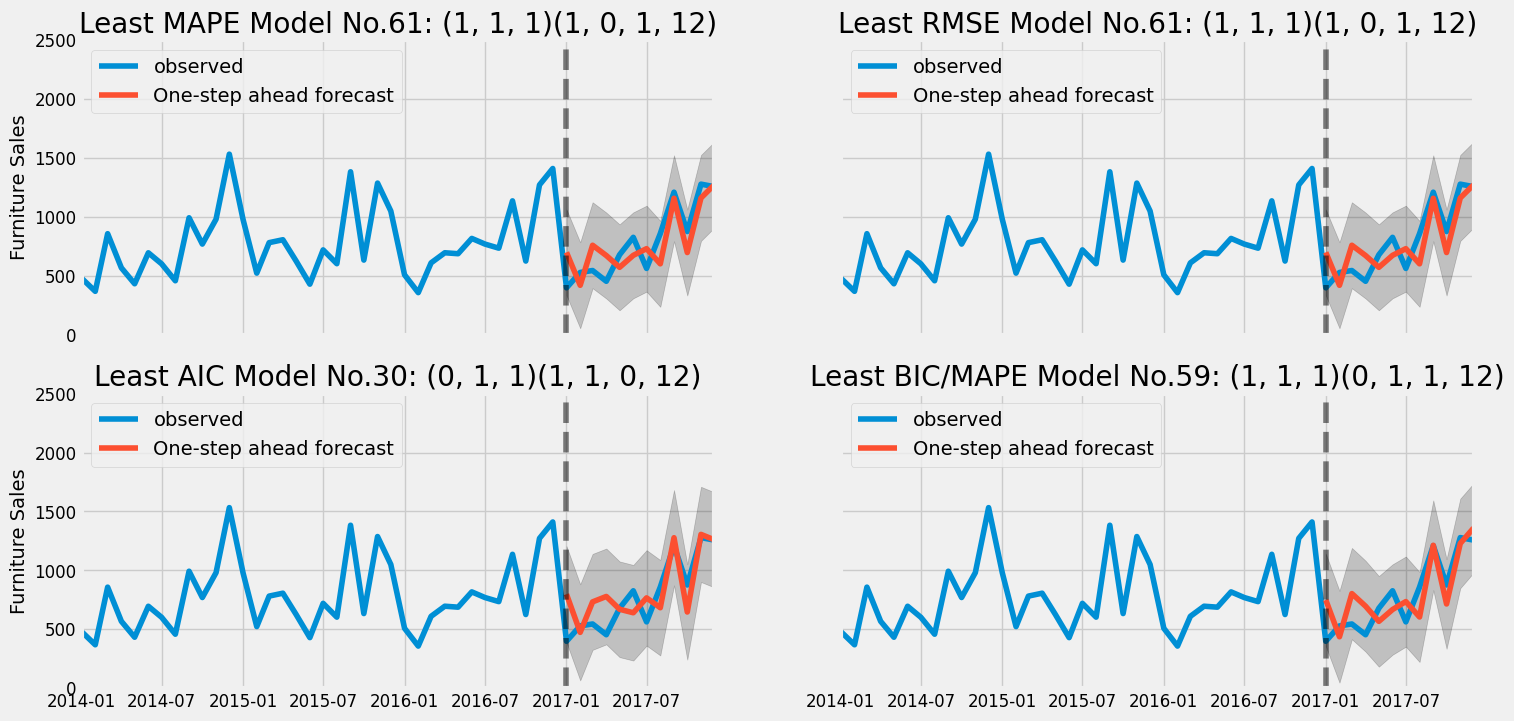

In [77]:
# fit the models of different order and seasonal order
order_list = df_model_params.order.tolist()
seasonal_order_list = df_model_params.seasonal_order.tolist()
ids = df_model_params.index.tolist()
model_types = ['MAPE','RMSE','AIC','BIC/MAPE']
titles=[f'Least {model_types[x]} Model No.{ids[x]}: {order_list[x]}{seasonal_order_list[x]}' for x in range(4)]

pred_list = []
y_lower_ci = [] # prediction confidence interval lower boundary
y_upper_ci = [] # prediction confidence interval upper boundary

for i in range(4):
    model = sm.tsa.statespace.SARIMAX(endog=y, order=order_list[i],
                                      seasonal_order=seasonal_order_list[i])
    result = model.fit(disp=0)

    pred_summary = result.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False).summary_frame()
    pred_list.append(pred_summary['mean'])
    y_lower_ci.append(pred_summary['mean_ci_lower'][pred_summary.index])
    y_upper_ci.append(pred_summary['mean_ci_upper'][pred_summary.index])


# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8),
                        sharex=True, sharey=True)
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(y, label='observed')
        axs[i,j].plot(pred_list[k], label='One-step ahead forecast')
        axs[i,j].set_title(titles[k])
        axs[i,0].set_ylabel('Furniture Sales')
        axs[i,j].legend()
        axs[i,j].axvline(pred_summary.index[0], color='black', alpha=0.5, linestyle='--')
        axs[i,j].fill_between(x=pred_summary.index, y1=y_lower_ci[k], y2=y_upper_ci[k], color='k', alpha=0.2)
        axs[i,j].set_ylim(bottom=0, top=2500)
        axs[i,j].set_xlim(left=y.index[0], right=y.index[-1])
        k += 1
plt.show()

# Chronos

>Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

1. [Chronos: Learning the language of time series](https://www.amazon.science/code-and-datasets/chronos-learning-the-language-of-time-series)
2. [Chronos-T5 (Large)](https://huggingface.co/amazon/chronos-t5-large)

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
import torch
from chronos import ChronosPipeline

In [ ]:
# data load
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = [12, 6]

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


<Axes: xlabel='Order Date'>

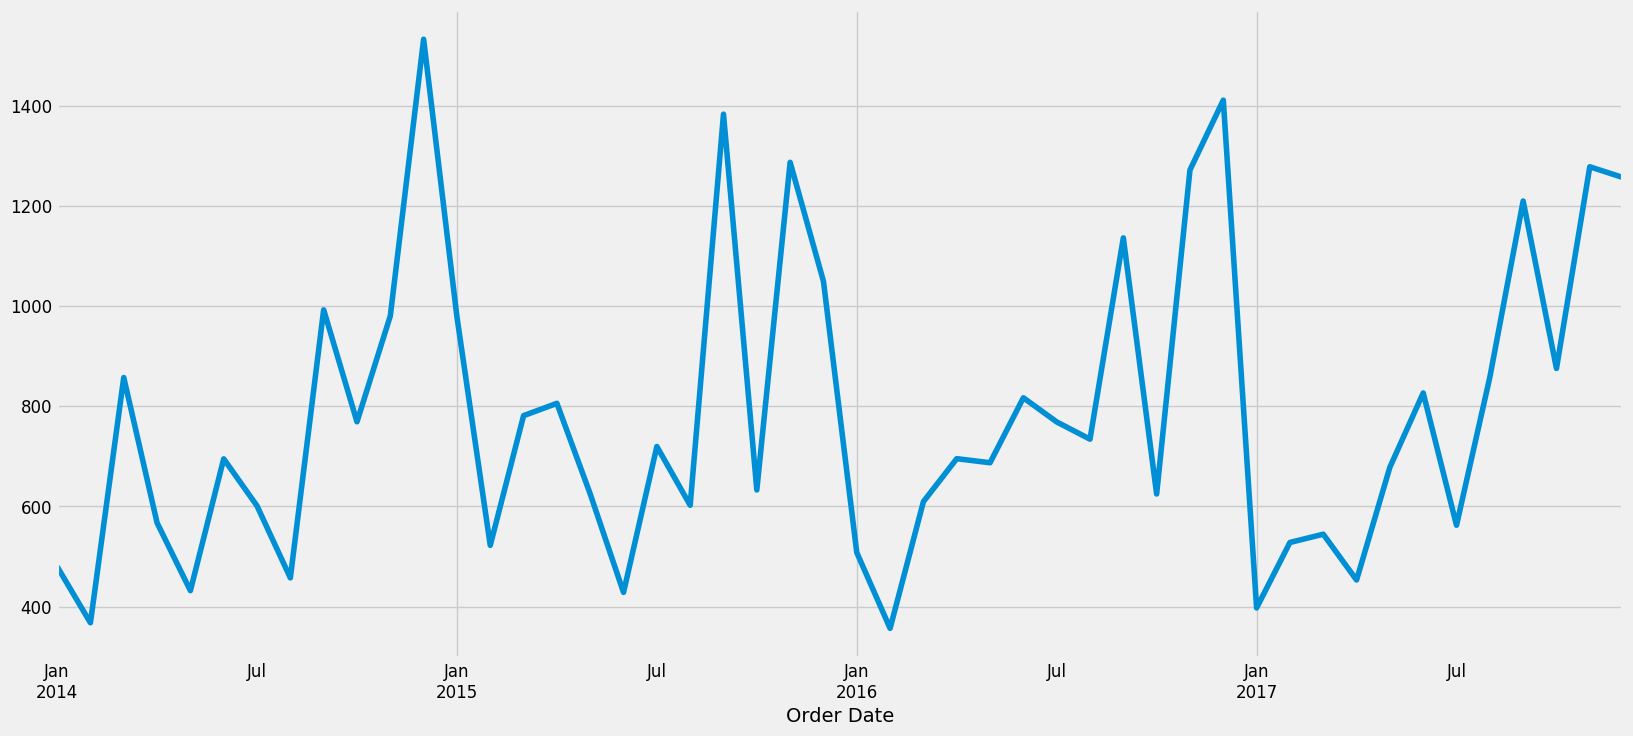

In [96]:
# データセットの目視確認
y.plot()

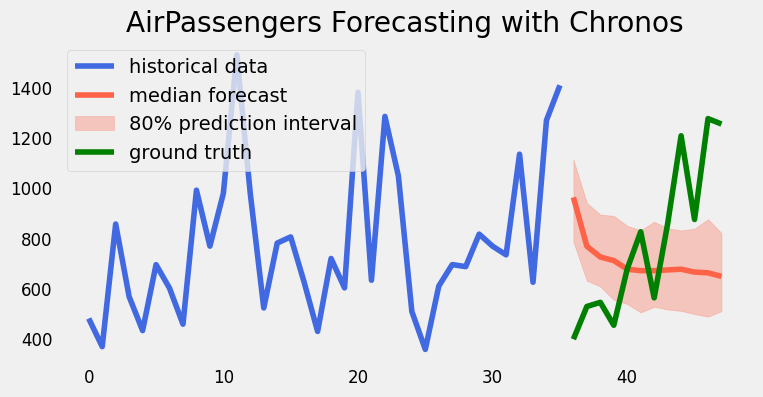

In [86]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
)

prediction_length = 12
train = y.values[:-prediction_length]
val = y.values[-prediction_length:]

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(train)

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=100,
)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(train), len(train) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(train, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(
    forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval"
)
plt.plot(range(len(train), len(train) + len(val)), val, color="green", label="ground truth")
plt.legend()
plt.title("AirPassengers Forecasting with Chronos")
plt.grid()
plt.show()

In [ ]:
forecast.shape

torch.Size([1, 100, 12])

In [94]:
def evaluate_model(val, median):

    mae = mean_absolute_error(val, median)
    rmse = root_mean_squared_error(val, median)
    mape = mean_absolute_percentage_error(val, median)

    return mae, rmse, mape

In [95]:
mae = mean_absolute_error(val, median)
rmse = root_mean_squared_error(val, median)
mape = mean_absolute_percentage_error(val, median)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

MAE: 305.06
RMSE: 367.81
MAPE: 41.86%
